In [497]:
import pandas as pd
import numpy as np
import os
import sys
import pdb
import doctest
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(".")
from Utils import Utils as Utils 

%matplotlib inline

In [498]:
excel_filepath = "../../DSS/Edify.ai/accident_hazardous_liquid_1986_jan2002.xlsx"
sample_df1 = pd.read_excel(excel_filepath)
sample_df1.head()

,RPTID,OPID,NAME,INTER,IDATE,DTHH,ACSTATE,ACCOUNTY,ACCITY,OFFSHORE,...,ONECL,ONEOT,EXCAL,TMPMK,RNAME,PHONE,TELRN,TELID,DOR,NARRATIVE
0,19850142,2731,CHEVRON PIPELINE CO,No,19851011,1430.0,TX,JEFFERSON,TOWN OF WINNIE,No,...,OTHER,MAILINGS TO EXCAVATORS,No,No,"JC PALMIERI, DIV. MGR.",4098922373,,,NaN,"ON OCTOBER 11, 1985 AN 8"" NATURAL GASOLINE PIP..."
1,19850143,2190,CENTRAL FLORIDA PIPELINE CORP,No,19851204,1830.0,FL,POLK,LAKE ALFRED,No,...,NO DATA,,Null,Null,"RALPH BAKER, MANAGER PIPELINES",8132472772,,,NaN,VALVE MALFUNCTION AT THE TAFT TERMINAL IN ORLA...
2,19850144,12628,MOBIL PIPELINE CO,No,19851115,1800.0,CA,LOS ANGELES,,No,...,NO DATA,,Null,Null,"J.B. GOZA, MANAGER",2133282550,,,NaN,"FAILURE OF 1"" NIPPLE CONNECTING A PRESSURE GAG..."
3,19850145,12628,MOBIL PIPELINE CO,No,19851123,1430.0,TX,WEBB,,No,...,OTHER,"AERIAL SURVEILLANCE, PIPE",No,No,"D.L. DENNARD, VICE PRESIDENT OPERATIONS",2146582226,,,NaN,AERIAL PATROL REPORTED A SMALL TRENCH ACROSS M...
4,19850146,15674,PLANTATION PIPE LINE CO,Yes,19850909,615.0,GA,DOUGLAS,,No,...,NO DATA,,Null,Null,"H.B. MCCAULEY, JR., VICE PRESIDENT-OPERATIONS",4042612137,,,NaN,"ON THE MORNING OF SEPTEMBER 9, 1985, PLANTATIO..."


In [499]:
#pdb.set_trace()

In [728]:
class BDTK:
    """
    The Big Data Analysis Toolkit. 
    
    Author: Aurum Kathuria
    
    This is the toolkit designed to optimize data anlysis and ML work done on behalf of Big Data at Berkeley. 
    Read the BDTK Handbook for an in-depth explanation of the purpose and features of the Toolkit.
    """
    
    def clean_name(self,name):
        Utils.type_check(name, str)
        return name[0].upper() + name[1:].lower()
    
    def __init__(self, df_in=None, **kwds):
        """ Creates a new BDTK Instance based off the pandas.DataFrame DF_IN, and uses the keyword args in **kwds.
        
        Parameters
        -------------------------------
        df_in: pandas.DataFrame object
            The dataframe on which to perform primary analysis
        **kwds: default None
            Optional keywords to pass in to this new BDTK object.
            
            Possible Keyword Arguments:
                filepath: str, path-like
                    Path to a stored csv file from which to extract a pandas DataFrame. 
                    'df_in' must be None for this to be used, otherwise df_in will be used and this will be ignored.
        
        Examples
        -------------------------------
        >>> BDTK(pd.DataFrame())
        DATAFRAME INFORMATION 
        SHAPE: (0, 0) 
        COLUMNS: Index([], dtype='object')
        >>>"""
        # Extract df_in from filepath if it doesn't exist, and ensure df_in is a pd.DataFrame
        if not Utils.type_check(df_in, pd.DataFrame, True):
            filepath = kwds.get("filepath", None)
            if not filepath:
                raise ValueError("No dataframe or filepath passed in. Each BDTK instance requires a dataframe to process. \
                                 Please pass in either a pandas.DataFrame obj or a path to a .csv file.")
            else: #filepath exists
                df_in = pd.read_csv(filepath)
        # df_in now exists for sure as a DataFrame, so let's add it to this object
        self.dataframe = df_in
        
        #initialize basic variables for the future
        self.data_types_dict = {}
        self.columns_to_figures = {}
        self.correlations = None
           
        # prep plotting aesthetics
        #set font size names
        SMALL_SIZE = 14
        MEDIUM_SIZE = 16
        BIGGER_SIZE = 22
        #set font sizes
        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
        plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        #set figure size
        plt.rcParams["figure.figsize"] = (14, 8) # size of the figure plotted
        #set color palettes
        self.qualitative_palette = sns.color_palette("husl")
        self.sequential_palette = sns.light_palette("#FDB515", 4)
        self.diverging_palette = sns.diverging_palette(h_neg=233, h_pos=52, s=95, l=75, center='light')
        sns.set_palette(self.qualitative_palette)#, color_codes=True)
        
        
    def data_types(self, sample_size=10, accuracy_threshold=0.5, display_unknowns=True):
        """Takes a random sample if sample_size values from each column, 
        and tries to deduce the type of data stored in that column 
        from the values.
        
        Parameters
        -------------------------------
        sample_size: int, *(future version: float)*
            The number of random values to look at in each column to identify the type of value. 
            *(The proportion of values to look at in each column to identify the type of value.)
        accuracy_threshold: float, >= 0 & <= 1
            The minimum proportion required to classify a column as of a specific type
        display_unknowns: boolean
            Whether to display the preset message when a column's data type is unknown. 
            Useful for debugging this function or your dataset when trying to understand
            why a column received the 'unknown' type classification.
                
        
        Returns
        -------------------------------
        A dictionary of column names to the data types of those columns. This dictionary is also
            stored as an instance attribute under 'self.data_types_dict'.
        
        
        See Also
        -------------------------------
        BDTK.column_distribution()
        
        Examples
        -------------------------------
        bdtk = new BDTK(df)
        bdtk.data_types()
        """
        
        Utils.type_check(sample_size, int)
        Utils.type_check(accuracy_threshold, [float, int])
        assert accuracy_threshold >= 0 and accuracy_threshold <= 1, "threshold must be between 0 and 1" 
        
        columns_to_data_types = {}
        for col_name in self.dataframe.columns:
            column = self.dataframe.loc[:, col_name]
            if len(column.shape) != 1:
                columns_to_data_types[col_name] = 'unknown: column shape incorrect'
                continue
            random_n_indices = np.random.choice(self.dataframe.index, size=sample_size, replace=False)
            random_n_values = column.loc[random_n_indices]
            types = random_n_values.apply(type)
            type_freqs = types.value_counts()
            #Ensure enough non-null values exist in the sample
            na_count = np.sum(random_n_values.isna())
            if na_count > sample_size*(1-accuracy_threshold):
                columns_to_data_types[col_name] = 'unknown: too many NaNs'
                if display_unknowns:
                    print(f"{col_name} has too many null values to determine type")
                    print(f"{na_count} null values out of {len(column)} values is a {na_count/len(column)*100}%" +
                          f"null value rate. At threshold {accuracy_threshold}, up to {sample_size*(1-accuracy_threshold)}"
                          f"null values are allowed.")
                continue
            #Determine qual. vs quant.
            if str(type_freqs.index[0]) == "<class 'str'>":
                columns_to_data_types[col_name] = 'qualitative'
            else:
                columns_to_data_types[col_name] = 'quantitative'
        self.data_types_dict = columns_to_data_types
        return columns_to_data_types
    
    
    def change_data_type(self, column_name, new_data_type):
        """Takes a column name columns_name and changes its stored data type to be 
        new_data_type.
        
        This is useful if a column appears to be quantitative, but is instead ordinal.
        Changing this results in different graphs being displayed as a result of
        bdtk.column_distribution() or bdtk.interactive_col_dist().
        
        
        Parameters
        -------------------------------
        column_name: str
            A name of a column in the dataframe self.dataframe. If not a valid column, 
            throws a ValueError.
        new_data_type: str
            This is the data type stored for the column column_name.
            Possible values are:
                "quantitative"
                "quant"
                "qualitative"
                "qual"
            Note: the abbreviated versions are stored as the whole versions for consistency.
            The abbreviations are only available for convenience here.
        
        
        Returns
        -------------------------------
        The new data type of the column.
        
        
        See Also
        -------------------------------
        BDTK.data_types()
        
        
        Examples
        -------------------------------
        bdtk = new BDTK(df)
        bdtk.data_types()
        bdtk.change_data_type('col1', 'quant')
        """
        #Setup
        Utils.type_check(column_name, str)
        Utils.type_check(new_data_type, str)
        assert column_name in self.dataframe.columns, "column_name must be in the dataframe's columns"
        if new_data_type=='quant':
            new_data_type = 'quantitative'
        elif new_data_type=='qual':
            new_data_type = 'qualitative'
        if new_data_type not in ['quantitative', 'qualitative']:
            raise ValueError("new data_type must be either 'quantitative', 'qualitative', or their abbreviations")
           
        #Change Type
        old_type = self.data_types_dict[column_name]
        self.data_types_dict[column_name] = new_data_type
        
        #return
        return self.data_types_dict[column_name]
    
    
    def column_distribution(self, base_column, compare_column=None, **kwargs):
        """Returns and optionally displays a visualization of the distribution of a quantitative column,
        optionally against a qualitative column.
        
        Will call self.data_types if self.data_types_dict is None, as this function
        requires information on the data type of the column to determine the type
        of plot to display.
        
        Parameters
        -------------------------------
        base_column: str
            The name of the column whose distribution is to be visualized.
        compare_column: str, default None
            The name of the column to compare distributions with the base_column.
        **kwargs: some additional specifications 
            show_unknowns: boolean, default True
                Whether to show the value_counts of the column as a DataFrame when the 
                data type is unknown.
            1D:
            
            2D:
                Quant vs. Quant:
                    trendline: boolean, default False
                        Whether to include the regression line, along with r squared and 
                        regression line equation, on the plot displayed. 
        
        
        Returns
        -------------------------------
            The AxesSubplot object and Figure object on which this plot is displayed.
        
        See Also 
        -------------------------------
        seaborn.regplot()
        seaborn.scatterplot()
        seaborn.kdeplot()
        seaborn.rugplot()
        seaborn.distplot()
        
        
        Examples
        -------------------------------
        bdtk = BDTK(DataFrame)
        bdtk.column_distribution(col1)
        bdtk.column_distribution(col3, col4)
        """
        # Setup
        Utils.type_check(base_column, str)
        assert base_column in self.dataframe.columns
        base_vals = self.dataframe.loc[:, base_column]
        if compare_column:
            Utils.type_check(compare_column, str)
            assert compare_column in self.dataframe.columns
            compare_vals = self.dataframe.loc[:, compare_column]
        if not self.data_types_dict:
            self.data_types(display_unknowns=False)
        clean_name = self.clean_name
        
        #Handle special keyword arguments
        trendline = kwargs.get('trendline', True)
        ci = (lambda: None if not trendline else 95)()
        
        
        # Define 2D Distribution Methods
        def quant_v_quant(base_column, compare_column):
            """Displays a Scatterplot, optionally with a trendline, comparing
            the distributions of two quantitative variables"""
            r_sq = self.dataframe[base_column].corr(self.dataframe[compare_column])
            sns.set_palette(palette=self.diverging_palette)
            if trendline:
                ax = sns.regplot(x=base_column, y=compare_column, data=self.dataframe,
                             ci=ci, fit_reg=trendline, label=f"r^2: {round(r_sq, 4)}")
                plt.legend(fontsize='large', edgecolor='r')
            else: #no trendline
                ax = sns.regplot(x=base_column, y=compare_column, data=self.dataframe,
                             ci=ci)
            plt.title(f"Comparing The Distribution of Values in \"{base_column}\" Against \"{compare_column}\"")
            plt.xlabel(f"{base_column} Values") 
            plt.ylabel(f"{compare_column} Values")
            plt.grid(True)
            #if len(base_uniques) > len(plt.xticks()):
                #plt.xticks(base_uniques.index)
            #if len(compare_uniques) > len(plt.yticks()):
                #plt.yticks(compare_uniques.index)
            return ax, fig
            
        def quant_v_qual(quant_col, qual_col):
            """Displays a Segmented Violin Plot comparing the distribution of 
            a quantitiative variable and a qualitative variable"""
            ax = sns.violinplot(x=qual_col, y=quant_col, data=self.dataframe, orient='v',
                               palette=self.qualitative_palette)
            ax.set(
                title=f"Comparing the Distribution of \"{quant_col}\" Against the Values in \"{qual_col}\"", 
                xlabel=f"Unique Values of \"{qual_col}\"",
                ylabel=f"Values of \"{quant_col}\""
            )
            plt.grid(True)
            return ax, fig
        
        def qual_vs_qual(x_column, y_column):
            """Will use a Segmented Bar Plot to count the number of observations 
            in overlapping categories
            
            future version:
                use https://randyzwitch.com/creating-stacked-bar-chart-seaborn/ to create
                a seaborn implementation of this            
            """
            #the line below handles finding a column from which the final output can be collected.
            #it is a stopgap fix and should be updated in the future, and will error if len(df.columns) == 2
            last_column = [col for col in self.dataframe.columns if col not in [x_column, y_column]][0]
            self.dataframe.groupby([x_column, y_column]).count().reset_index().pivot(x_column, y_column, last_column)
            
            otu = minimal_df.groupby([x_column, y_column]).count().reset_index()
            otu = otu.pivot(x_column, y_column, last_column).fillna(0)
            prev_height = np.zeros(len(otu.index))
            i = 0
            for i in range(len(otu.columns)):
                height = np.array(otu.iloc[:, i])
                plt.bar(x=list(otu.index), height=height, bottom=prev_height, 
                        label=f"\"{y_column}\"={otu.columns[i]}")
                prev_height = [prev_height[i] + height[i] for i in np.arange(height.shape[0])]
            plt.legend()
            plt.ylim(top=max(prev_height)*1.1)

            plt.title(f"Comparing the Values of \"{x_column}\" Against the Values in \"{y_column}\"")
            plt.xlabel(f"Unique Values of \"{x_column}\"")
            plt.ylabel(f"Unique Values of \"{y_column}\"")
            return None, fig
        
        # Prep to Graph
        neat_basecol_name = clean_name(base_column)
        ax = None
        fig = plt.figure(figsize=(14, 8))
        base_data_type = self.data_types_dict[base_column]
        
        # 1D Distribution
        if not compare_column:
            base_vals = base_vals[~base_vals.isna()]
            if base_data_type == "quantitative":
                sns.set_palette(palette=self.diverging_palette)
                ax = sns.distplot(base_vals)
            if base_data_type == "qualitative":
                val_counts = base_vals.value_counts()
                ax = sns.barplot(x=val_counts.index, y=val_counts, palette=self.sequential_palette)
                plt.title("The Distribution of Values in " + base_column)
                plt.xlabel("Unique Values of " + base_column) 
                plt.ylabel("Counts")
            if ax == None and kwargs.get('show_unknowns', False):
                print("Data Type for Column Unknown. Displaying Value Counts.")
                display(pd.DataFrame(base_vals.value_counts()))           
        else:
            base_uniques = self.dataframe[base_column].value_counts()
            compare_uniques = self.dataframe[compare_column].value_counts()
            compare_data_type = self.data_types_dict[compare_column]
            if base_data_type == 'quantitative' and compare_data_type == 'quantitative':
                print("2D Quant vs. Quant => Scatterplot")
                return quant_v_quant(base_column, compare_column)
            if base_data_type == 'quantitative' and compare_data_type == 'qualitative':
                print("2D Quant vs. Qual => Violin Plot")
                return quant_v_qual(base_column, compare_column)
            if base_data_type == 'qualitative' and compare_data_type == 'quantitative':
                print("2D Qual vs. Quant => Violin Plot")
                return quant_v_qual(compare_column, base_column)
            if base_data_type == 'qualitative' and compare_data_type == 'qualitative':
                print("2D Qual vs. Qual => Stacked Bar Plot")
                return qual_vs_qual(base_column, compare_column)
            
        return ax, fig
        
    
    def interactive_col_dist(self, hide_plot=False):
        """Displays an interactive visualization of the distribution of a column, optionally 
        against another column. 
            
            Currently Supported Data Types:
                1D: 
                    - quant
                    - qual
                2D: 
                    - quant vs. quant
                    - quant vs. qual (same as qual vs. quant for displayed figure)
                    - qual vs. qual
        
        Will call self.data_types if self.data_types_dict is None, as this function
        requires information on the data type of the column to determine the type
        of plot to display.
        
        Parameters
        -------------------------------
        hide_plot: boolean, default False
            A way to hide the plot and save memory when the plot is no longer needed but 
            the code is desired to remain.  
        
        Returns
        -------------------------------
            The interactive object to visualize column relationships.
        
        See Also 
        -------------------------------
        BDTK.column_distribution()        
        
        Examples
        -------------------------------
        bdtk = BDTK(DataFrame)
        bdtk.interactive_col_dist()
        bdtk.interactive_col_dist(hide_plot=True)
        """
        #hide_plot functionality
        if hide_plot:
            return None
        
        # Create widgets
        base_column_widget = widgets.Dropdown(options=bdtk.dataframe.columns)
        compare_column_widget = widgets.Dropdown(options=[None, *bdtk.dataframe.columns])
        #trendline_widget = widgets.Checkbox(value=False, indent=True, description="Show Trendline")
        switch_columns_widget = widgets.Button(description="Switch Columns")
        
        #organize widgets into boxes
        column_selection_vbox_widget = widgets.VBox([base_column_widget, compare_column_widget])
        column_manipulation_hbox_widget = widgets.HBox([column_selection_vbox_widget, switch_columns_widget])
        output = widgets.Output()
        
        # Updates the graph based on the widgets' values
        def display_graph(*args):
            output.clear_output()
            with output:
                display(bdtk.column_distribution(base_column_widget.value, compare_column_widget.value))
        def switch_values_and_options(*args):
            old_base_val = base_column_widget.value 
            old_comp_val = compare_column_widget.value
            compare_column_widget.value = old_base_val
            base_column_widget.value = old_comp_val or base_column_widget.options[0] #to handle the edge case of compare column = None
            display_graph()
            
        #create button onclick handlers
        switch_columns_widget.on_click(switch_values_and_options)
        
        # Tie the compare_column options to base_column value
        base_column_widget.observe(display_graph, 'value')
        # Tie the base_column options to compare_column value
        compare_column_widget.observe(display_graph, 'value')
        
        interacter = interactive(bdtk.column_distribution, 
                 base_column=base_column_widget, 
                 compare_column=compare_column_widget)

        #return display(interacter)
        display(column_manipulation_hbox_widget)
        display_graph()
        return display(output)
    
    def __repr__(self):
        return f"DATAFRAME INFORMATION \n" + \
            f"SHAPE: {self.dataframe.shape} \n" + \
            f"COLUMNS: {self.dataframe.columns}"

In [729]:
# if median - mode > 10% * average(median, mode), call it skewed & use log

In [730]:
#minimal_df = sample_df1.loc[np.random.choice(sample_df1.index, size=20), np.random.choice(sample_df1.columns, size=7)]
#minimal_df = sample_df1[["NINJ", "TINJ", "ITMYR", "ACPRS", "THK", "OPID"]]
minimal_df = sns.load_dataset("tips")
minimal_df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [731]:
bdtk = BDTK(minimal_df)
_ = bdtk.data_types()
bdtk.dataframe.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


Output()

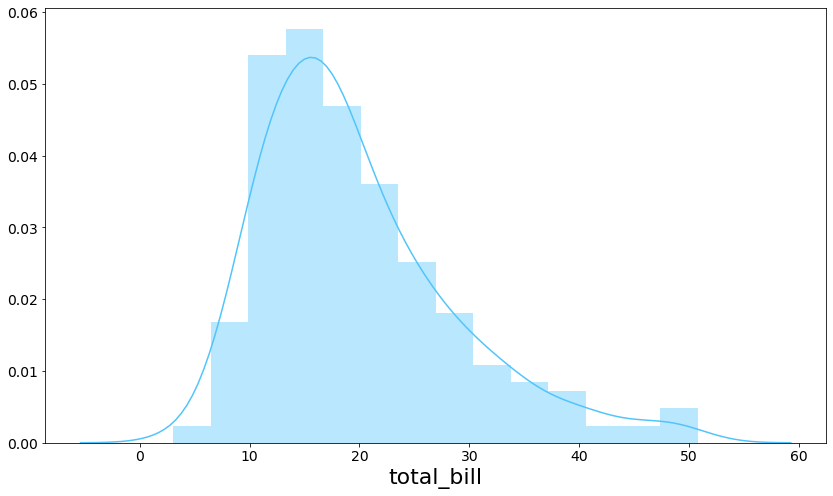

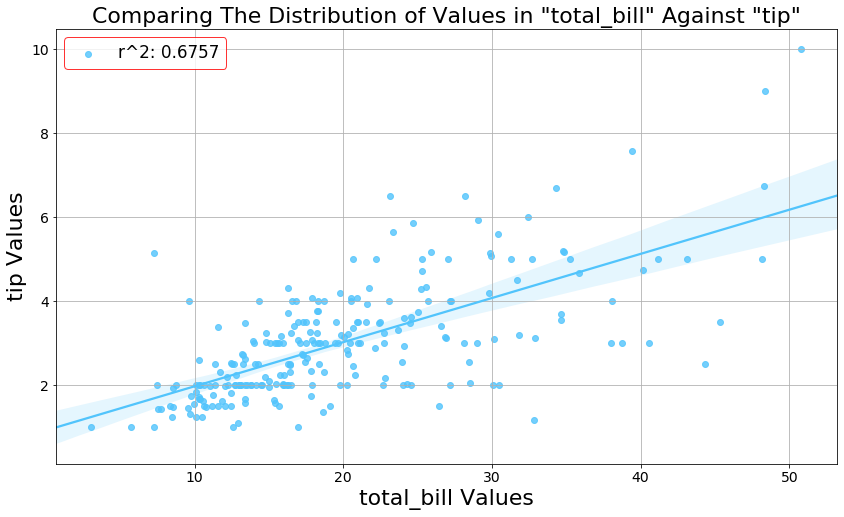

In [732]:
#display(bdtk.data_types_dict)
#bdtk.data_types_dict['size'] = 'qualitative'
bdtk.change_data_type('size', 'qual')
bdtk.interactive_col_dist()

In [654]:
#bdtk.column_distribution("total_bill", "tip")

In [613]:
bdtk2 = BDTK(sample_df1)

In [557]:
df = bdtk.dataframe

"""def show_values_more_than(self, 
                          mini=0, maxi=100, step=10
                          operator1=[>, >=, =, <=, <, !=], 
                          operator2=[>, >=, =, <=, <, !=, None]):
    def helper(column=self.dataframe.columns, 
               value_lims=(mini, maxi, step), 
               ):
    
    return df.loc[df[column] > x]"""

'def show_values_more_than(self, \n                          mini=0, maxi=100, step=10\n                          operator1=[>, >=, =, <=, <, !=], \n                          operator2=[>, >=, =, <=, <, !=, None]):\n    def helper(column=self.dataframe.columns, \n               value_lims=(mini, maxi, step), \n               ):\n    \n    return df.loc[df[column] > x]'

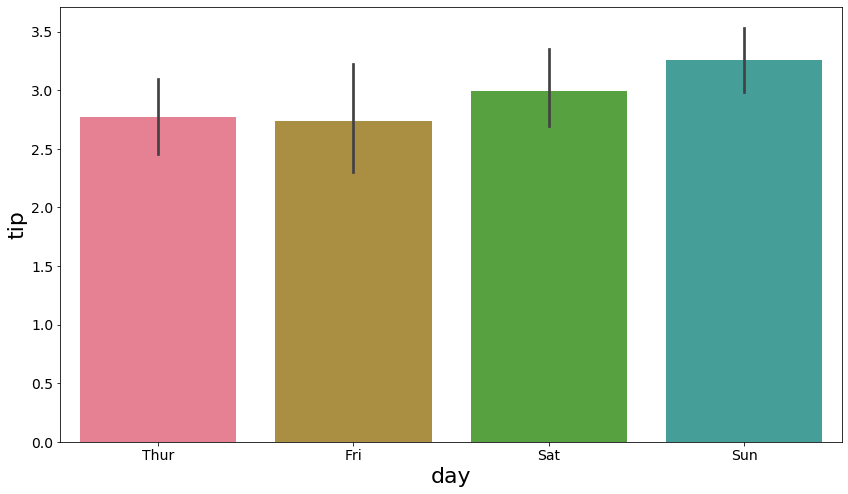

In [559]:
pal = sns.color_palette("husl")
#pal = sns.diverging_palette(h_neg=233, h_pos=52, s=95, l=75, center='light')
#pal = sns.light_palette("#FDB515", 4)
sns.barplot(minimal_df['day'], minimal_df['tip'], palette=pal)
#self.sequential_palette = sns.sequential_palette()
#self.diverging_palette = sns.diverging_palette(h_neg="#003262", h_pos='#C4820E', center='light')

In [375]:
otu = minimal_df.groupby(['day', 'size']).count().reset_index().pivot('day', 'size', 'total_bill').fillna(0)
otu

size,1,2,3,4,5,6
day,,,,,,
Thur,1.0,48.0,4.0,5.0,1.0,3.0
Fri,1.0,16.0,1.0,1.0,0.0,0.0
Sat,2.0,53.0,18.0,13.0,1.0,0.0
Sun,0.0,39.0,15.0,18.0,3.0,1.0


In [376]:
list(otu.index), otu.iloc[:, 0]

(['Thur', 'Fri', 'Sat', 'Sun'], day
 Thur    1.0
 Fri     1.0
 Sat     2.0
 Sun     0.0
 Name: 1, dtype: float64)

In [377]:
otu.index

CategoricalIndex(['Thur', 'Fri', 'Sat', 'Sun'], categories=['Thur', 'Fri', 'Sat', 'Sun'], ordered=False, name='day', dtype='category')

(0.0, 95.7)

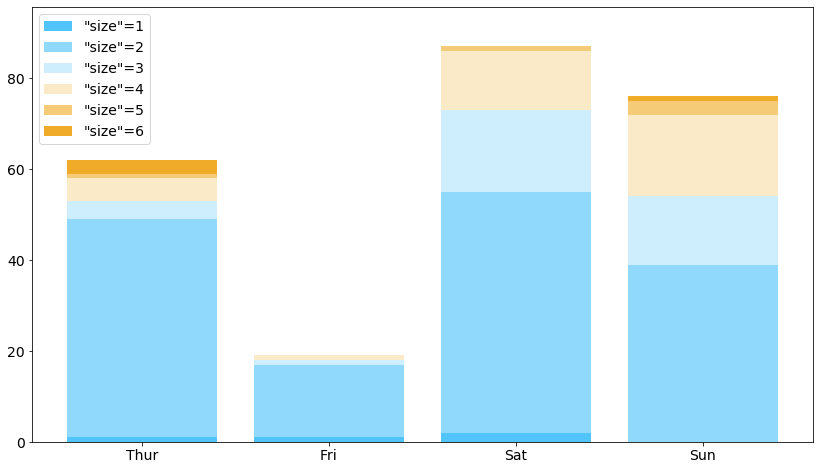

In [385]:
prev_height = np.zeros(len(otu.index))
i = 0
for i in range(len(otu.columns)):
    height = np.array(otu.iloc[:, i])
    plt.bar(x=list(otu.index), height=height, bottom=prev_height, label=f"\"size\"={otu.columns[i]}")
    prev_height = [prev_height[i] + height[i] for i in np.arange(height.shape[0])]
plt.legend()
plt.ylim(top=max(prev_height)*1.1)

In [ ]:
[0, 0, 0, 0]